In [4]:
import numpy as np
from scipy.stats import multivariate_normal as N
from metrics import *
import matplotlib.pyplot as plt

# Exercise 2

In [5]:
# start: 20:20
def kMeans(D, k, eps, mu = None):
    
    # initialize centroids
    d = D.shape[1]
    if mu is None:
        mu = np.random.rand(k, d) * (np.max(D, axis=0) - np.min(D, axis=0)) + np.min(D, axis=0)
    if type(mu) == list:
        mu = np.array(mu)
    
    # main loop
    stop = False
    while not stop:
        
        # compute closest cluster for each point
        C = []
        for x in D:
            closestCluster = np.argmin([np.linalg.norm(mu[j]-x) for j in range(k) if not any(np.isnan(mu[j]))])
            C.append(closestCluster)
            
        # update centroids
        newMu = np.zeros(mu.shape)
        stop = True
        for i in range(k):
            newMu[i] = np.mean([D[j] for j in range(len(D)) if C[j] == i], axis=0)
            if np.linalg.norm(mu[i] - newMu[i]) > eps:
                stop = False
        mu = newMu
    return C, mu

# end: 20:35

# start 20:40
def EM(D, k, eps, mu=None, independent=False): 
    
    # initialize means, covariance matrices, and priors
    d = D.shape[1]
    r = np.max(D) - np.min(D)
    if mu is None:
        mu = np.random.rand(k, d) * (np.max(D, axis=0) - np.min(D, axis=0)) + np.min(D, axis=0)
    if type(mu) != np.array:
        mu = np.array(mu)
    cov = [r * np.eye(d) for i in range(k)] # co-variances
    P = [1 / k for i in range(k)] # priors
    
    stop = False
    while not stop:
                
        # Expectation Step
        w = np.zeros((k, len(D)))
        for j, x in enumerate(D):
            px = [N.pdf(x, mu[a], cov[a]) for a in range(k)] # probability vector for point
            s = np.sum([px[a] * P[a] for a in range(k)], axis = 0)
            if s == 0:
                raise Exception("Sum is 0 for point " + str(x) + ". Initialize cov with higher variances. Means are:\n" + str(mu) + "\nand COVs are \n" + str(cov))
            for i in range(k):
                w[i][j] = px[i] * P[i] / s
                if np.isnan(w[i][j]):
                    raise Exception("Invalid weight " + str(fi(x, mu[i], cov[i])) )
            if np.abs(w[:,j].sum() - 1) > 0.001:
                raise Exception("Weights for " +str(j) +"-th instance " + str(x) + " sum up to " + str(w[:,j].sum()) + " instead of 1!")
        
        # Maximization Step
        muNew = np.zeros(mu.shape)
        for i in range(k):
            wi = np.sum(w[i])
            muNew[i] = (np.sum([w[i][j] * x for j, x in enumerate(D)], axis=0) / wi).reshape(1, d)
            if independent:
                cov[i] = sum([w[i][j] * np.diag([(x-mu[i])[u]**2 for u in range(d)]) for j, x in enumerate(D)]) / wi
            else:
                cov[i] = sum([w[i][j] * np.matmul((x - mu[i]).reshape(d, 1), (x - mu[i]).reshape(1, d)) for j, x in enumerate(D)]) / wi
            
            P[i] = wi / len(D)
        if np.abs(sum(P) - 1) > 0.01:
            raise Exception("P vector " + str(P) + " does not sum up to " + str(sum(P)) + " != 1!")
            
        # Convergence check
        stop = True
        for i in range(k):
            diff = np.linalg.norm(mu[i] - muNew[i])
            if diff > eps:
                stop = False
        mu = muNew
    return np.round(w, 4), mu, cov

# end: 21:49




K-Means
----------------------------------
Centroid 1: ok
Centroid 2: ok
Centroid 3: ok
Clustering: ok


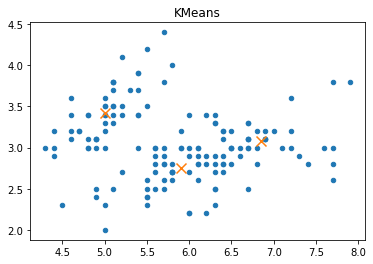


EM
----------------------------------
Centroid 1: ok
Centroid 2: ok
Centroid 3: ok
EM: Probabilities ok


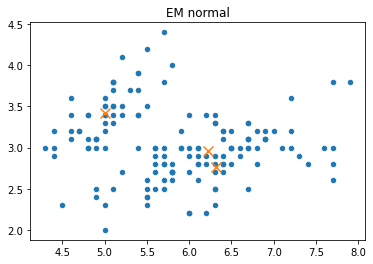

Centroid 1: ok
Centroid 2: ok
Centroid 3: ok
EM: Probabilities ok


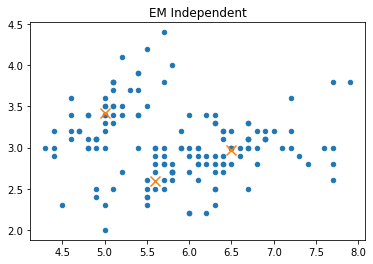

In [12]:
## CLUSTERING UNIT TESTS
import pandas as pd
import matplotlib.pyplot as plt

def check_centroids(name, centroids_expected, centroids_actual):
    
    # check centroids
    mapping = []
    for i, expected_centroid in enumerate(centroids_expected):
        found = False
        for j, actual_centroid in enumerate(centroids_actual):
            if all(np.isclose(np.round(expected_centroid,2), np.round(actual_centroid, 2))):
                found = True
                mapping.append(j)
                break
        print("Centroid " + str(i+1) + ": " + ("ok" if found else "failed (did not find centroid " + str(expected_centroid) + ")"))
    return mapping
    
def check_probabilities(name, mapping, probsE, probsA):
    P_copy = []
    for j in mapping:
        P_copy.append(probsA[j])
    P = np.round(np.array(P_copy), 2)
    print(name + ": Probabilities " + ("ok" if np.array_equal(np.round(probsE, 2), P) else "FAILED (mismatches in positions " + str(np.where(~np.isclose(probsE, P))[0]) + ")"))

def check_clustering(name, mapping, clustering_expected, clustering_actual):
    C_copy = np.array(clustering_actual.copy())
    for i, j in enumerate(mapping):
        C_copy[clustering_actual == j] = i
    C = list(C_copy)
    mismatches = C != clustering_expected
    print("Clustering: " + ("ok" if np.count_nonzero(mismatches) == 0 else "failed (mismatches in positions " + str(np.where(mismatches)) + ")"))

def check_kmeans(centroids_expected, centroids_actual, clustering_expected, clustering_actual):
    name = "KMeans"
    mapping = check_centroids(name, centroids_expected, centroids_actual)
    check_clustering(name, mapping, clustering_expected, clustering_actual)
    
def check_em(centroids_expected, centroids_actual, probs_expected, probs_actual):
    name = "EM"
    mapping = check_centroids(name, centroids_expected, centroids_actual)
    check_probabilities(name, mapping, probs_expected, probs_actual)

dfIris = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
DIris = dfIris.values[:, :4].astype(float)

mu_init = list(np.array([[3,3,3,3], [4,4,4,4], [5,5,5,5]]))
expected_centroids_kmeans = np.array([[5.006, 3.418, 1.464, 0.244], [5.9016129, 2.7483871, 4.39354839, 1.43387097], [6.85, 3.07368421, 5.74210526, 2.07105263]])
expected_clustering_kmeans = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1]

print("\nK-Means\n----------------------------------")

# KMeans Iris
C, muA = kMeans(DIris, 3, 0.05, mu=mu_init)
muA = np.array(muA)
check_kmeans(expected_centroids_kmeans, muA, expected_clustering_kmeans, C)
fig, ax = plt.subplots()
ax.scatter(DIris[:,0], DIris[:,1], s=20)
ax.scatter(muA[:,0], muA[:,1], marker="x", s=100)
ax.set_title("KMeans")
plt.show()


## EM Unit Tests

print("\nEM\n----------------------------------")

# EM dependent
probsE = np.array([[1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.999e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.661e-01, 1.000e+00, 9.999e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00], [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.390e-02, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.294e-01, 7.330e-01, 8.859e-01, 9.412e-01, 7.398e-01, 1.025e-01, 4.511e-01, 9.681e-01, 8.156e-01, 1.855e-01, 9.970e-01, 3.139e-01, 9.620e-01, 3.979e-01, 8.798e-01, 8.920e-01, 4.680e-02, 8.120e-02, 9.543e-01, 8.447e-01, 2.500e-03, 9.014e-01, 8.708e-01, 5.850e-02, 8.783e-01, 8.648e-01, 8.895e-01, 4.059e-01, 3.700e-01, 9.793e-01, 9.396e-01, 9.190e-01, 9.028e-01, 2.133e-01, 1.010e-02, 2.290e-01, 8.248e-01, 9.802e-01, 3.782e-01, 8.024e-01, 4.800e-02, 4.568e-01, 8.882e-01, 9.915e-01, 4.504e-01, 1.898e-01, 4.140e-01, 8.085e-01, 9.977e-01, 6.277e-01, 0.000e+00, 6.000e-04, 5.930e-02, 1.735e-01, 1.000e-04, 9.976e-01, 2.000e-04, 9.964e-01, 9.664e-01, 0.000e+00, 2.000e-04, 2.670e-02, 3.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 3.120e-01, 9.996e-01, 9.979e-01, 9.537e-01, 0.000e+00, 0.000e+00, 9.999e-01, 2.010e-02, 4.200e-03, 9.795e-01, 7.100e-03, 8.000e-03, 4.000e-04, 9.633e-01, 9.911e-01, 9.999e-01, 0.000e+00, 4.988e-01, 6.300e-03, 2.000e-04, 0.000e+00, 1.800e-01, 3.400e-03, 1.000e-04, 0.000e+00, 0.000e+00, 6.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e-03, 4.000e-04, 0.000e+00, 5.100e-03], [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 7.060e-02, 2.670e-01, 1.141e-01, 5.880e-02, 2.602e-01, 8.975e-01, 5.489e-01, 3.190e-02, 1.844e-01, 8.145e-01, 3.000e-03, 6.861e-01, 3.800e-02, 6.021e-01, 1.202e-01, 1.080e-01, 9.532e-01, 9.188e-01, 4.570e-02, 1.553e-01, 9.975e-01, 9.860e-02, 1.292e-01, 9.415e-01, 1.217e-01, 1.352e-01, 1.105e-01, 5.941e-01, 6.300e-01, 2.070e-02, 6.040e-02, 8.100e-02, 9.720e-02, 7.867e-01, 9.899e-01, 7.710e-01, 1.752e-01, 1.980e-02, 6.218e-01, 1.976e-01, 9.520e-01, 5.432e-01, 1.118e-01, 8.500e-03, 5.496e-01, 8.102e-01, 5.860e-01, 1.915e-01, 2.300e-03, 3.723e-01, 1.000e+00, 9.994e-01, 9.407e-01, 8.265e-01, 9.999e-01, 2.400e-03, 9.998e-01, 3.600e-03, 3.360e-02, 1.000e+00, 9.998e-01, 9.733e-01, 9.997e-01, 1.000e+00, 1.000e+00, 1.000e+00, 6.880e-01, 4.000e-04, 2.100e-03, 4.630e-02, 1.000e+00, 1.000e+00, 1.000e-04, 9.799e-01, 9.958e-01, 2.050e-02, 9.929e-01, 9.920e-01, 9.996e-01, 3.670e-02, 8.900e-03, 1.000e-04, 1.000e+00, 5.012e-01, 9.937e-01, 9.998e-01, 1.000e+00, 8.200e-01, 9.966e-01, 9.999e-01, 1.000e+00, 1.000e+00, 9.994e-01, 1.000e+00, 1.000e+00, 1.000e+00, 9.970e-01, 9.996e-01, 1.000e+00, 9.949e-01]])
muE = np.array([[5.00634312, 3.41875822, 1.4641106 , 0.24396087], [6.317633  , 2.76772266, 4.70159228, 1.45230374], [6.2179487 , 2.95223591, 5.06177387, 1.8480251 ]])
probsA, muA, cov = EM(DIris, 3, 0.01, mu=mu_init, independent=False)
muA = np.array(muA)
check_em(muE, muA, probsE, probsA)
fig, ax = plt.subplots()
ax.scatter(DIris[:,0], DIris[:,1], s=20)
ax.scatter(muA[:,0], muA[:,1], marker="x", s=100)
ax.set_title("EM normal")
plt.show()

# EM independent
probsE = np.array([[1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00], [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e-04, 0.000e+00, 9.989e-01, 1.200e-03, 8.486e-01, 0.000e+00, 9.999e-01, 6.200e-03, 9.912e-01, 1.000e+00, 1.649e-01, 9.983e-01, 3.490e-02, 9.935e-01, 7.000e-04, 1.097e-01, 9.938e-01, 1.882e-01, 9.994e-01, 0.000e+00, 9.073e-01, 2.500e-03, 3.428e-01, 1.629e-01, 3.300e-03, 1.000e-04, 0.000e+00, 4.040e-02, 9.995e-01, 9.998e-01, 9.998e-01, 9.958e-01, 1.000e-04, 1.632e-01, 2.000e-04, 0.000e+00, 7.641e-01, 9.522e-01, 9.978e-01, 9.909e-01, 3.880e-02, 9.963e-01, 9.999e-01, 9.846e-01, 9.557e-01, 9.430e-01, 4.493e-01, 9.999e-01, 9.777e-01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.010e-02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.890e-02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00], [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 9.995e-01, 1.000e+00, 1.100e-03, 9.988e-01, 1.514e-01, 1.000e+00, 1.000e-04, 9.938e-01, 8.800e-03, 0.000e+00, 8.351e-01, 1.700e-03, 9.651e-01, 6.500e-03, 9.993e-01, 8.903e-01, 6.200e-03, 8.118e-01, 6.000e-04, 1.000e+00, 9.270e-02, 9.975e-01, 6.572e-01, 8.371e-01, 9.967e-01, 9.999e-01, 1.000e+00, 9.596e-01, 5.000e-04, 2.000e-04, 2.000e-04, 4.200e-03, 9.999e-01, 8.368e-01, 9.998e-01, 1.000e+00, 2.359e-01, 4.780e-02, 2.200e-03, 9.100e-03, 9.612e-01, 3.700e-03, 1.000e-04, 1.540e-02, 4.430e-02, 5.700e-02, 5.507e-01, 1.000e-04, 2.230e-02, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.799e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.811e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.999e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]])
muE = np.array([[5.006, 3.418, 1.464, 0.244], [5.59707706, 2.59785749, 3.93059583, 1.18968012], [6.49606953, 2.96850503, 5.2493667 , 1.84719678]])
probsA, muA, cov  = EM(DIris, 3, 0.05, mu=np.array([[1,1,1,1], [2,2,2,2], [3,3,3,3]]), independent=True)
check_em(muE, muA, probsE, probsA)
fig, ax = plt.subplots()
ax.scatter(DIris[:,0], DIris[:,1], s=20)
ax.scatter(muA[:,0], muA[:,1], marker="x", s=100)
ax.set_title("EM Independent")
plt.show()

In [22]:
import itertools as it
dfIris = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
DIris = dfIris.values[:, :4].astype(float)
mu_init = list(np.array([[3,3,3,3], [4,4,4,4], [5,5,5,5]]))
C, mu = kMeans(DIris, 3, 0.05, mu=mu_init)
for i, x in enumerate(DIris):
    closest_cluster = np.argmin([np.linalg.norm(mu[i] - x) for i in range(len(mu))])
    print(closest_cluster, C[i])
    
#or combo in it.combinations(range(4), 2):
#   plotClusters(DIris, C, combo[0], combo[1])

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
2 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
2 2
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
2 2
1 1
2 2
2 2
2 2
2 2
1 1
2 2
2 2
2 2
2 2
2 2
2 2
1 1
1 1
2 2
2 2
2 2
2 2
1 1
2 2
1 1
2 2
1 1
2 2
2 2
1 1
1 1
2 2
2 2
2 2
2 2
2 2
1 1
2 2
2 2
2 2
2 2
1 1
2 2
2 2
2 2
1 1
2 2
2 2
2 2
1 1
2 2
2 2
1 1


# Exercise 3